In [1]:
import scanpy as sc
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as ss
from scipy.sparse.linalg import eigs
from tqdm import tqdm

## Data Preprocessing

In [2]:
adata = sc.read_h5ad('./data/hnd.h5ad')

In [3]:
if not isinstance(adata.X, np.ndarray):
    adata.X = adata.X.toarray()
adata

AnnData object with n_obs × n_vars = 604 × 13771
    obs: 'Sample_ID', 'Experiment', 'Day', 'Number of Alignments', 'Cell Quality Control', 'Outlier', 'Subpopulations', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'geneid', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'

In [4]:
sc.pp.filter_cells(adata, min_genes=1)
sc.pp.filter_genes(adata, min_cells=1)

In [5]:
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)

In [6]:
obs_time = 'Day'
sorted_time = ['d0', 'd1', 'd5', 'd7', 'd10', 'd30']
adata.obs[obs_time] = adata.obs[obs_time].cat.reorder_categories(sorted_time)

## Dimensionality Reduction with PCA

In [7]:
sc.tl.pca(adata)

C:\Users\51895\AppData\Roaming\Python\Python38\site-packages\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


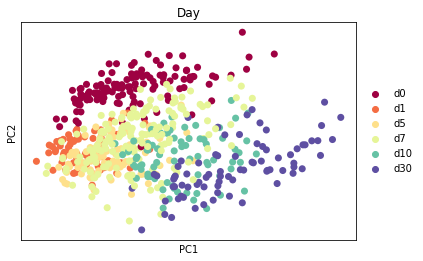

In [8]:
sc.pl.pca(adata, color=obs_time, palette=plt.cm.Spectral.name)

In [9]:
time_colors = dict(zip(sorted_time, adata.uns['{}_colors'.format(obs_time)]))

## Calculating Complexity Indices for Cells and Genes

In [10]:
def complexity_index(mcg):
    mgc = np.transpose(mcg)
    
    kc0 = np.sum(mcg, axis=1)
    kg0 = np.sum(mcg, axis=0)
    
    mcc = np.dot(mcg / np.transpose([kc0]), mgc / np.transpose([kg0]))
    
    e_val, e_vec = eigs(mcc)    
    cci = np.real(e_vec[:, 1])
    
    scc = ss.spearmanr(kc0, cci)[0]
    if scc < 0:
        cci = - cci
        
    gci = np.dot(mgc, np.transpose([cci])).flatten() / kg0
    
    cci = (cci - np.min(cci)) / (np.max(cci) - np.min(cci))
    gci = (gci - np.min(gci)) / (np.max(gci) - np.min(gci))
    
    return cci, gci

In [11]:
cci, gci = complexity_index(adata.X)

## Calculating Complexity at Each Order for Cells and Genes

In [12]:
def cg_complexity(mcg, nmax=30):
    mcg = mcg.astype(np.float64)
    mgc = np.transpose(mcg)
    
    kc = []
    kg = []
    
    kc.append(np.sum(mcg, axis=1))
    kg.append(np.sum(mcg, axis=0))

    for n in range(1, nmax):       
        kc.append(np.dot(mcg, np.transpose([kg[n-1]])).flatten() / kc[0])
        kg.append(np.dot(mgc, np.transpose([kc[n-1]])).flatten() / kg[0])

    kc = np.array(kc)
    kg = np.array(kg)
    
    max_kc = np.max(kc, axis=1).reshape(kc.shape[0], 1)
    min_kc = np.min(kc, axis=1).reshape(kc.shape[0], 1)
    kc = (kc - min_kc) / (max_kc - min_kc)

    max_kg = np.max(kg, axis=1).reshape(kg.shape[0], 1)
    min_kg = np.min(kg, axis=1).reshape(kg.shape[0], 1)
    kg = (kg - min_kg) / (max_kg - min_kg)
    
    return kc, kg

In [13]:
kc, kg = cg_complexity(adata.X)

## Computing CytoTRACE Gene Scores

In [14]:
import scvelo as scv
from cellrank.kernels import CytoTRACEKernel

sc.pp.highly_variable_genes(adata)
print(f"This detected {np.sum(adata.var['highly_variable'])} highly variable genes. ")

adata.layers["spliced"] = adata.X
adata.layers["unspliced"] = adata.X
scv.pp.moments(adata, n_pcs=30, n_neighbors=30)

ctk = CytoTRACEKernel(adata).compute_cytotrace()

This detected 2269 highly variable genes. 
computing neighbors
    finished (0:00:07) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:01) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


In [15]:
ct_score_gene = []
ct_pseudotime = adata.obs['ct_pseudotime']
ct_score_cell = -ct_pseudotime

for i in tqdm(range(adata.X.shape[1])):
    ct_score_gene.append(ss.pearsonr(adata.X[:, i], ct_score_cell)[0])
ct_score_gene = np.array(ct_score_gene)

100%|██████████████████████████████████████████████████████████████████████████| 13771/13771 [00:01<00:00, 9208.17it/s]


## Marker Gene

In [16]:
# sc.tl.rank_genes_groups(adata, obs_time, method='t-test')
sc.tl.rank_genes_groups(adata, obs_time, method='wilcoxon')

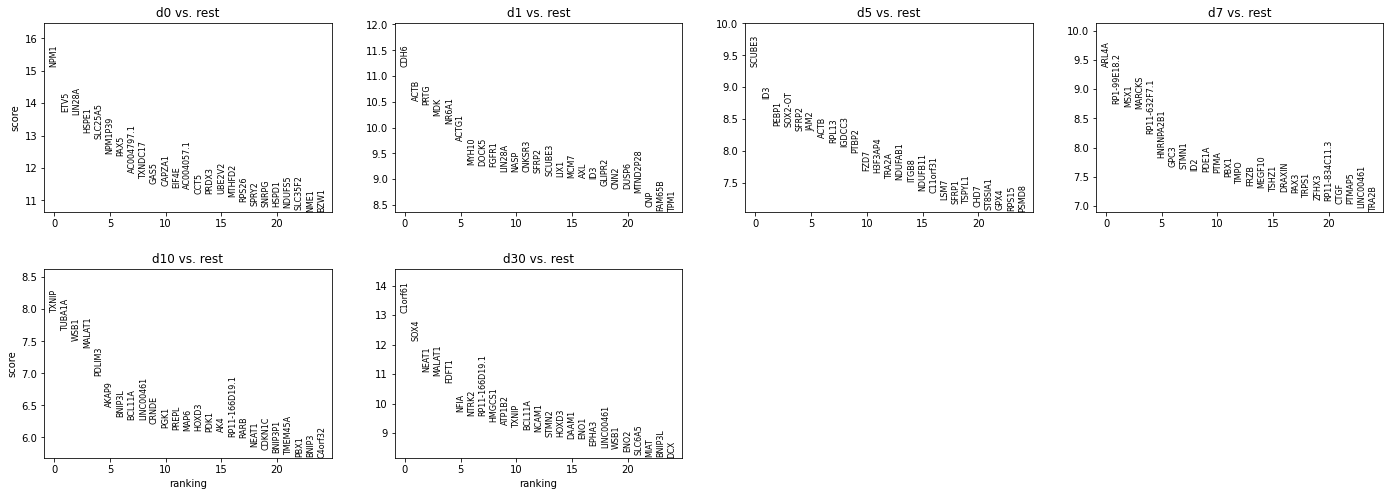

In [17]:
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

## Ranking Top 10 Marker Genes at Each Time Point

In [18]:
ntop = 10

In [19]:
t_marker = {}
for t in sorted_time:
    t_marker[t] = []
for markers in adata.uns['rank_genes_groups']['names'][: ntop]:
    for i in range(len(markers)):
        t_marker[sorted_time[i]].append(markers[i])

In [20]:
t_score = {}
for t in sorted_time:
    t_score[t] = []
for scores in adata.uns['rank_genes_groups']['scores'][:ntop]:
    for i in range(len(markers)):
        t_score[sorted_time[i]].append(scores[i])

In [21]:
marker_score = {}
marker_t = {}
for t in sorted_time:
    for i in range(len(t_marker[t])):
        marker = t_marker[t][i]
        score = t_score[t][i]
        if marker not in marker_t:
            marker_t[marker] = t
            marker_score[marker] = score
        else:
            if score > marker_score[marker]:
                marker_t[marker] = t
                marker_score[marker] = score

In [22]:
from matplotlib.path import Path
import matplotlib.patches as patches

def convert_to_ranking(score_array):
    ranking_2d = np.empty(score_array.shape, dtype=int)
    for i in range(ranking_2d.shape[1]):
        pos = np.argsort(score_array[:, i])
        for j, pos in enumerate(pos):
            ranking_2d[pos, i] = j
        
    return ranking_2d

def ranking_plot(t, colors):
    fig, ax = plt.subplots(figsize=(10, 19))

    indent = 0.8

    for tj, color in zip(t, colors):
        s = ax.scatter(np.arange(len(tj)), tj, marker='o', color=color, s=100, zorder=3)
        verts = [(i + d, tij) for i, tij in enumerate(tj) for d in (-indent, 0, indent)][1:-1]
        codes = [Path.MOVETO] + [Path.CURVE4] * (len(verts) - 1)
        path = Path(verts, codes)
        patch = patches.PathPatch(path, facecolor='none', lw=3, edgecolor=color)
        ax.add_patch(patch)

    return fig, ax

In [23]:
indices = np.where(np.isin(list(adata.var.index), list(marker_t.keys())))[0]

In [24]:
marker_kg = kg[:, indices]
marker_gci = gci[indices]
marker_gct = ct_score_gene[indices]

order_list = list(range(1, 10, 2))
score_array = marker_kg[order_list]
score_array = np.vstack([marker_gct, score_array])
score_array = np.vstack([score_array, marker_gci])
score_array = np.transpose(score_array)

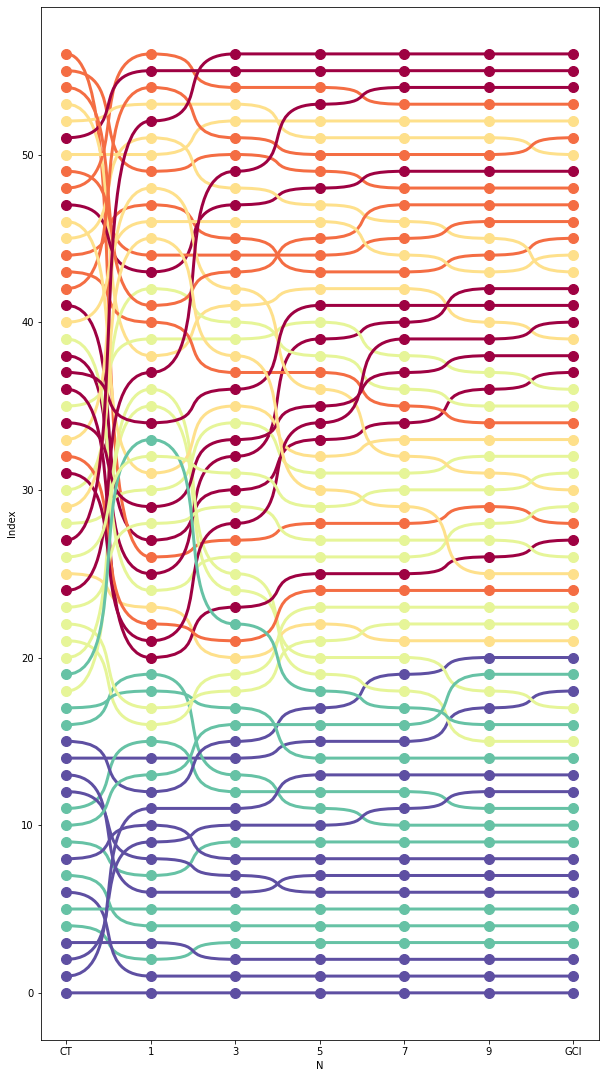

In [25]:
ranking = convert_to_ranking(score_array)
color_list = [time_colors[marker_t[marker]] for marker in adata.var.index[indices]]
fig, ax = ranking_plot(ranking, color_list)

xticks = ['CT']
xticks.extend([str(i) for i in order_list])
xticks.append('GCI')
ax.set_xticks([0, 1, 2, 3, 4, 5, 6])
ax.set_xticklabels(xticks)
ax.set_xlabel('N')
ax.set_ylabel('Index')
plt.show()

## Spearman Correlation Between Gene Rankings and Developmental Order

In [26]:
reverse_order = [i for i in range(len(sorted_time))]
reverse_order = reverse_order[::-1]
t_reverse_order = dict(zip(sorted_time, reverse_order))

In [27]:
marker_reverse_order = []
for i in indices:
    marker = adata.var.index[i]
    t = t_reverse_order[marker_t[marker]]
    marker_reverse_order.append(t)

In [28]:
scc_marker = [ss.spearmanr(ct_score_gene[indices], marker_reverse_order)[0]]
for i in range(1, 11, 2):
    scc_marker.append(ss.spearmanr(marker_kg[i], marker_reverse_order)[0])
scc_marker.append(ss.spearmanr(marker_gci, marker_reverse_order)[0])

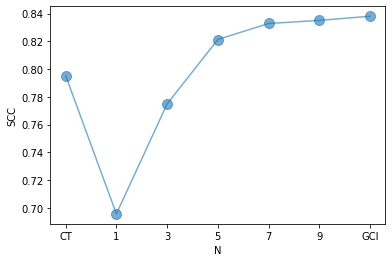

In [29]:
plt.plot(scc_marker, marker='o', markersize=10, alpha=0.6)
plt.xticks([0, 1, 2, 3, 4, 5, 6], xticks)
plt.xlabel('N')
plt.ylabel('SCC')
plt.show()